# Question 2

In [22]:
import gymnasium
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [114]:
# creating the Random Walk Environment (RWE)
class RandomWalkExperiment(gymnasium.Env):

  metadata = {"render_modes" : ["human", "rgb_array"], "render_fps": 4}

  def __init__(self, render_mode = None, slip_prob = 0.5):

    self.size = 7
    self.window_size = 512
    self.observation_space = spaces.Discrete(7) # 5 non-terminal and 2 terminal states
    self.action_space = spaces.Discrete(2) # left and right
    # defining the transition probs
    self.transition = {
        0 : {
            0 : [(1.0, 0, 0, True)],
            1 : [(1.0, 0, 0, True)]
        },
        1 : {
            0 : [(0.5, 0, 0, True), (0.5, 2, 0, False)],
            1 : [(0.5, 2, 0, False), (0.5, 0, 0, True)]
        },
        2 : {
            0 : [(0.5, 1, 0, False), (0.5, 3, 0, False)],
            1 : [(0.5, 1, 0, False), (0.5, 3, 0, False)]
        },
        3 : {
            0 : [(0.5, 2, 0, False), (0.5, 4, 0, False)],
            1 : [(0.5, 2, 0, False), (0.5, 4, 0, False)]
        },
        4 : {
            0 : [(0.5, 3, 0, False), (0.5, 5, 0, False)],
            1 : [(0.5, 3, 0, False), (0.5, 5, 0, False)]
        },
        5 : {
            0 : [(0.5, 4, 0, False), (0.5, 6, 1, True)],
            1 : [(0.5, 6, 1, True), (0.5, 4, 0, False)]
        },
        6 : {
            0 : [(1.0, 6, 1, True)],
            1 : [(1.0, 6, 1, True)]
        },
    }
    self.window = None
    self.clock = None
    self.slip_prob = slip_prob

  def reset(self, seed = None):
    # Starting the random walk from the middle
    self.state = (self.size + 1)//2
    # self.state = 6
    return self.state

  def step(self, action):

    if np.random.rand() < self.slip_prob:
      action = 1 if action == 0 else 0

    transitions = self.transition[self.state][action]
    tprobs, next_states, rewards, terminate = zip(*transitions)
    next_state_index = np.random.choice(range(len(next_states)), p = tprobs)
    next_state = next_states[next_state_index]
    reward = rewards[next_state_index]
    done = terminate[next_state_index]

    # moving to the next state
    self.state = next_state
    return next_state, reward, done, {}

In [115]:
# Implementing the generateTrajectory function with maxsteps
def generateTrajectory(env, policy, maxSteps):
  state = env.reset(seed = 123)
  trajectory = []
  for _ in range(maxSteps):
    # choosing an action from policy
    action = policy[state] # pi(a|s)
    next_state, reward, done, _ = env.step(action)
    trajectory.append((state, action, reward, next_state, done))
    if done:
      break
    state = next_state

  if done:
    return trajectory
  else:
    return [] # discard partial trajectories


In [116]:
env = RandomWalkExperiment()
policy = [0] * env.observation_space.n # according to the question, the policy is "Always go left -> 0"
maxSteps = 100
seed = 123
trajectory = generateTrajectory(env, policy, maxSteps)
print("Printing Trjactory")
print(trajectory)
print("Total number of states encountered : {}".format(len(trajectory)))

Printing Trjactory
[(4, 0, 0, 5, False), (5, 0, 1, 6, True)]
Total number of states encountered : 2


In [192]:
# Implementing a function for deacaying the step parameter
def decayAlpha(initialValue, finalValue, maxSteps, decayType):

  # stpring the step params in a list
  alphas = []

  if decayType == "linear":
   decay_rate = (finalValue - initialValue) / maxSteps
   for curr_step in range(maxSteps):
    curr_alpha = initialValue + decay_rate * curr_step
    alphas.append(curr_alpha)

  elif decayType == "exponential":
    decay_rate = (np.log(finalValue/initialValue)) / maxSteps
    for curr_step in range(maxSteps):
      curr_alpha = initialValue * np.exp(decay_rate * curr_step)
      alphas.append(curr_alpha)

  return alphas

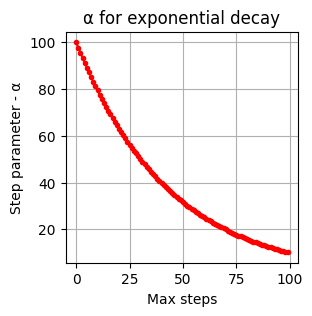

In [193]:
decayType = "exponential"
maxSteps = 100
alphas = decayAlpha(100, 10, maxSteps, decayType)

# plotting the alphas
plt.figure(figsize = (3, 3))
plt.plot(range(maxSteps), alphas, color = "red", marker = ".")
plt.ylabel("Step parameter - α")
plt.xlabel("Max steps")
plt.title("α for {} decay".format(decayType))
plt.grid(True)
plt.show()

In [177]:

def MonteCarloPrediction(env, policy, initialValue, finalValue, maxSteps, numEpisodes, gamma, decayType, mctype):

    # initialize the values with zeros
    values = np.zeros(env.observation_space.n)
    values_eps = []
    returns = {s: [] for s in range(env.observation_space.n)}
    # calculate the step params for each episode
    alphas = decayAlpha(initialValue, finalValue, numEpisodes, decayType)

    # Iterating over the numEpisodes
    for episode in range(numEpisodes):
        # generating the trajectory for each episode
        trajectory = generateTrajectory(env, policy, maxSteps)
        if not trajectory:
            continue
        G = 0
        visited_states = set()

        # Traversing the trajectory in reverse order
        for traj_idx in range(len(trajectory)-1, -1, -1):
            state, action, reward, next_state, done = trajectory[traj_idx]
            G = gamma * G + reward

            if mctype == "FVMC" and state not in visited_states:
                if state not in visited_states:
                    values[state] += alphas[episode] * (G - values[state])
                    visited_states.add(state)
            elif mctype == "EVMC":
                values[state] += alphas[episode] * (G - values[state])

        values_eps.append(np.copy(values))

    return values_eps

In [178]:
gamma = 0.99
numEpisodes = 100
mctype = "EVMC"
initialValue = 0.5
finalValue = 0.01
decayType = "exponential"

values = MonteCarloPrediction(env, policy, initialValue, finalValue, maxSteps, numEpisodes, gamma, decayType, mctype)
print(values[numEpisodes -1])

[0.         0.19325723 0.45251885 0.58378753 0.69668206 0.8587298
 0.        ]


In [175]:
# Implementing the Temporal Difference learning approach
def TemporalDifferencePrediction(env, policy, intialValue, finalValue, maxSteps, numEpisodes, gamma, decayType):

  # Initialize the values with zeros
  values = np.zeros(env.observation_space.n)
  returns = {s : [] for s in range(env.observation_space.n)}
  alphas = decayAlpha(intialValue, finalValue, numEpisodes, decayType)
  values_eps = []

  for episode in range(numEpisodes):

    # reseting the environment
    state = env.reset(seed = 123)
    for step in range(0, maxSteps):
      # choosing an action from policy function
      action = policy[state]
      next_state, reward, done, _ = env.step(action)
      td_target = reward  # TD target

      if not done:
        td_target = td_target + gamma * values[next_state]
      td_error = td_target - values[state]
      values[state] = values[state] + alphas[episode] * td_error
      state = next_state

    values_eps.append(np.copy(values))

  return values_eps

In [176]:
gamma = 0.99
numEpisodes = 100
initialValue = 0.5
finalValue = 0.01
decayType = "exponential"

values = TemporalDifferencePrediction(env, policy, initialValue, finalValue, maxSteps, numEpisodes, gamma, decayType)
print(values[numEpisodes - 1])

[0.         0.11162393 0.2567955  0.44106033 0.65041698 0.84045768
 1.        ]


# Part 5

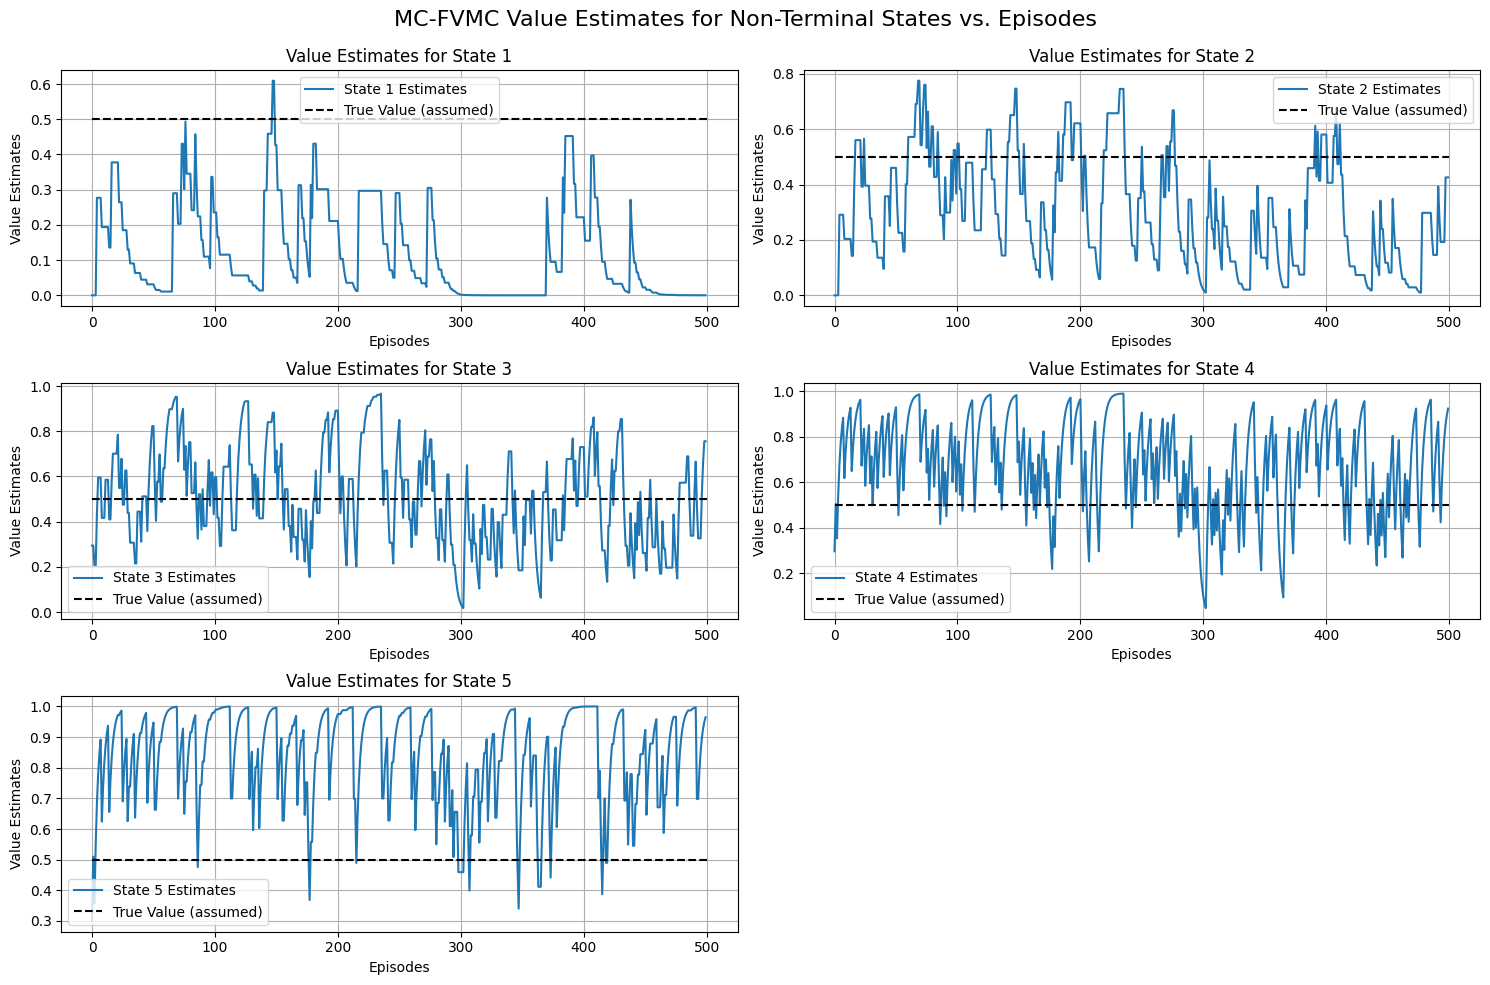

In [185]:
numEpisodes = 500
# part with constant alpha
initialValue = 0.3
finalValue = 0.3
maxSteps = 100
gamma = 0.99
decayType = "linear"
mctype = "FVMC"

state_values = MonteCarloPrediction(env, policy, initialValue, finalValue, maxSteps, numEpisodes, gamma, decayType, mctype)

plt.figure(figsize=(15, 10))

for state in range(1, 6):  # Loop through non-terminal states
    plt.subplot(3, 2, state)
    values_per_state = [state_values[episode][state] for episode in range(numEpisodes)]
    plt.plot(values_per_state, label=f'State {state} Estimates')
    plt.plot([0, numEpisodes], [0.5, 0.5], 'k--', label="True Value (assumed)")
    plt.xlabel('Episodes')
    plt.ylabel('Value Estimates')
    plt.title(f'Value Estimates for State {state}')
    plt.legend()
    plt.grid()
    plt.tight_layout()

plt.suptitle('MC-FVMC Value Estimates for Non-Terminal States vs. Episodes', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()


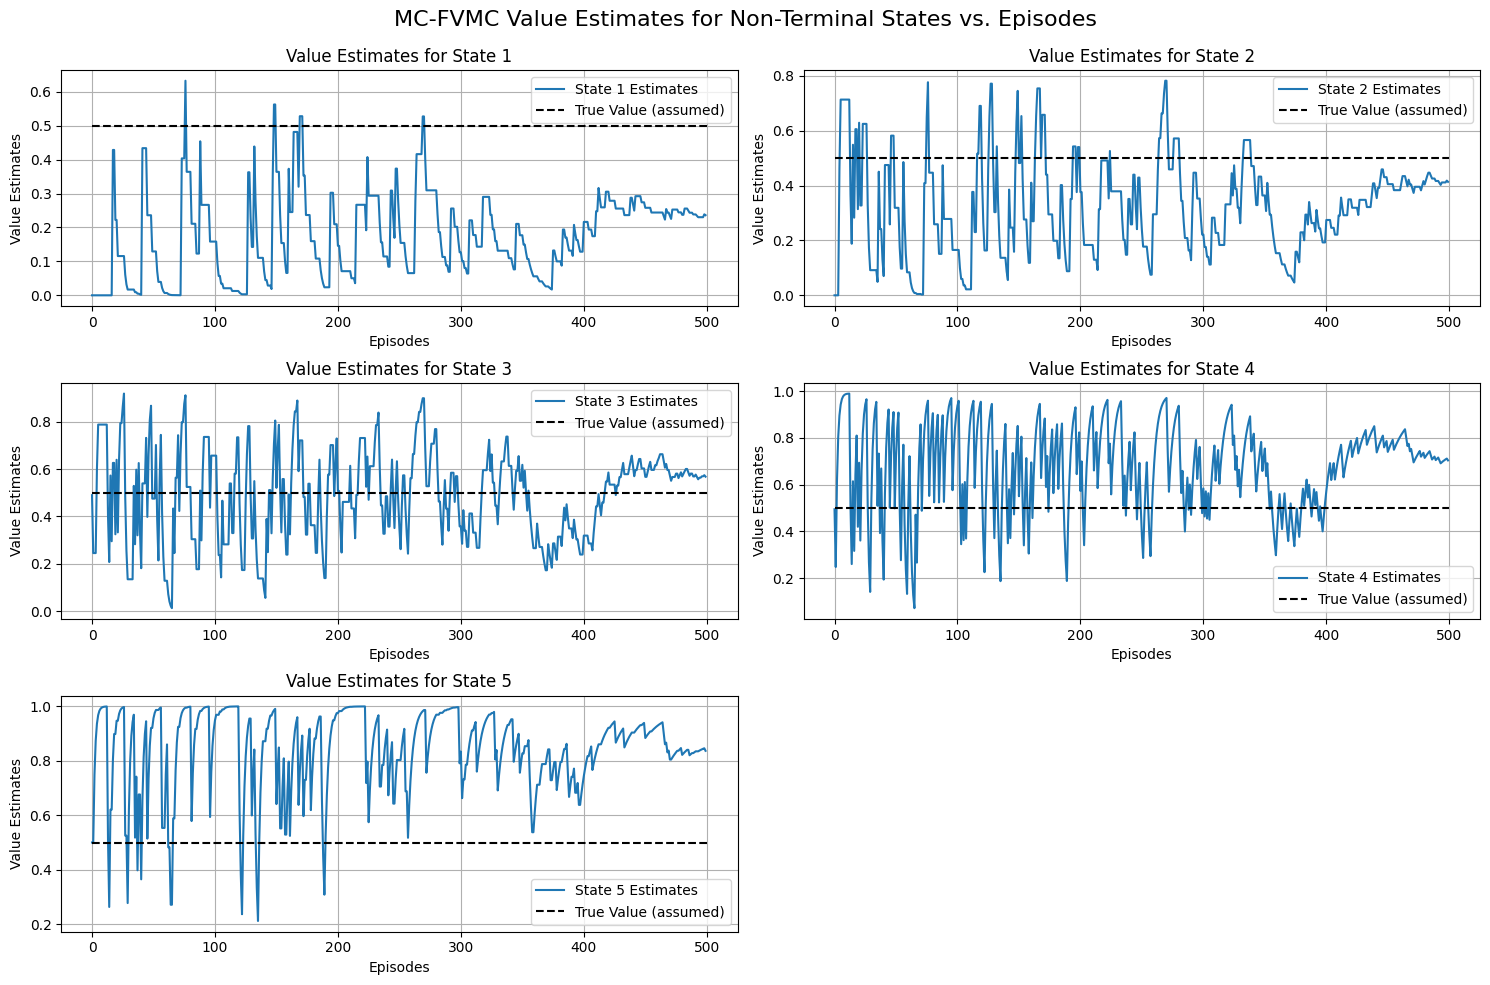

In [188]:
# part with decaying alpha
numEpisodes = 500
# part with constant alpha
initialValue = 0.5
finalValue = 0.01
maxSteps = 100
gamma = 0.99
decayType = "linear"
mctype = "FVMC"

# Implementing a function for deacaying the step parameter for half episodes and using const value afterwards
def decayAlpha_modified(initialValue, finalValue, maxSteps, decayType):

  # stpring the step params in a list
  alphas = []

  decay_rate = (np.log(finalValue/initialValue)) / maxSteps
  for curr_step in range(maxSteps//2):
    curr_alpha = initialValue * np.exp(decay_rate * curr_step)
    alphas.append(curr_alpha)
  for i in range(maxSteps//2, maxSteps):
    alphas.append(curr_alpha)

  return alphas

state_values = MonteCarloPrediction(env, policy, initialValue, finalValue, maxSteps, numEpisodes, gamma, decayType, mctype)

plt.figure(figsize=(15, 10))

for state in range(1, 6):  # Loop through non-terminal states
    plt.subplot(3, 2, state)
    values_per_state = [state_values[episode][state] for episode in range(numEpisodes)]
    plt.plot(values_per_state, label=f'State {state} Estimates')
    plt.plot([0, numEpisodes], [0.5, 0.5], 'k--', label="True Value (assumed)")
    plt.xlabel('Episodes')
    plt.ylabel('Value Estimates')
    plt.title(f'Value Estimates for State {state}')
    plt.legend()
    plt.grid()
    plt.tight_layout()

plt.suptitle('MC-FVMC Value Estimates for Non-Terminal States vs. Episodes', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

# Part 6


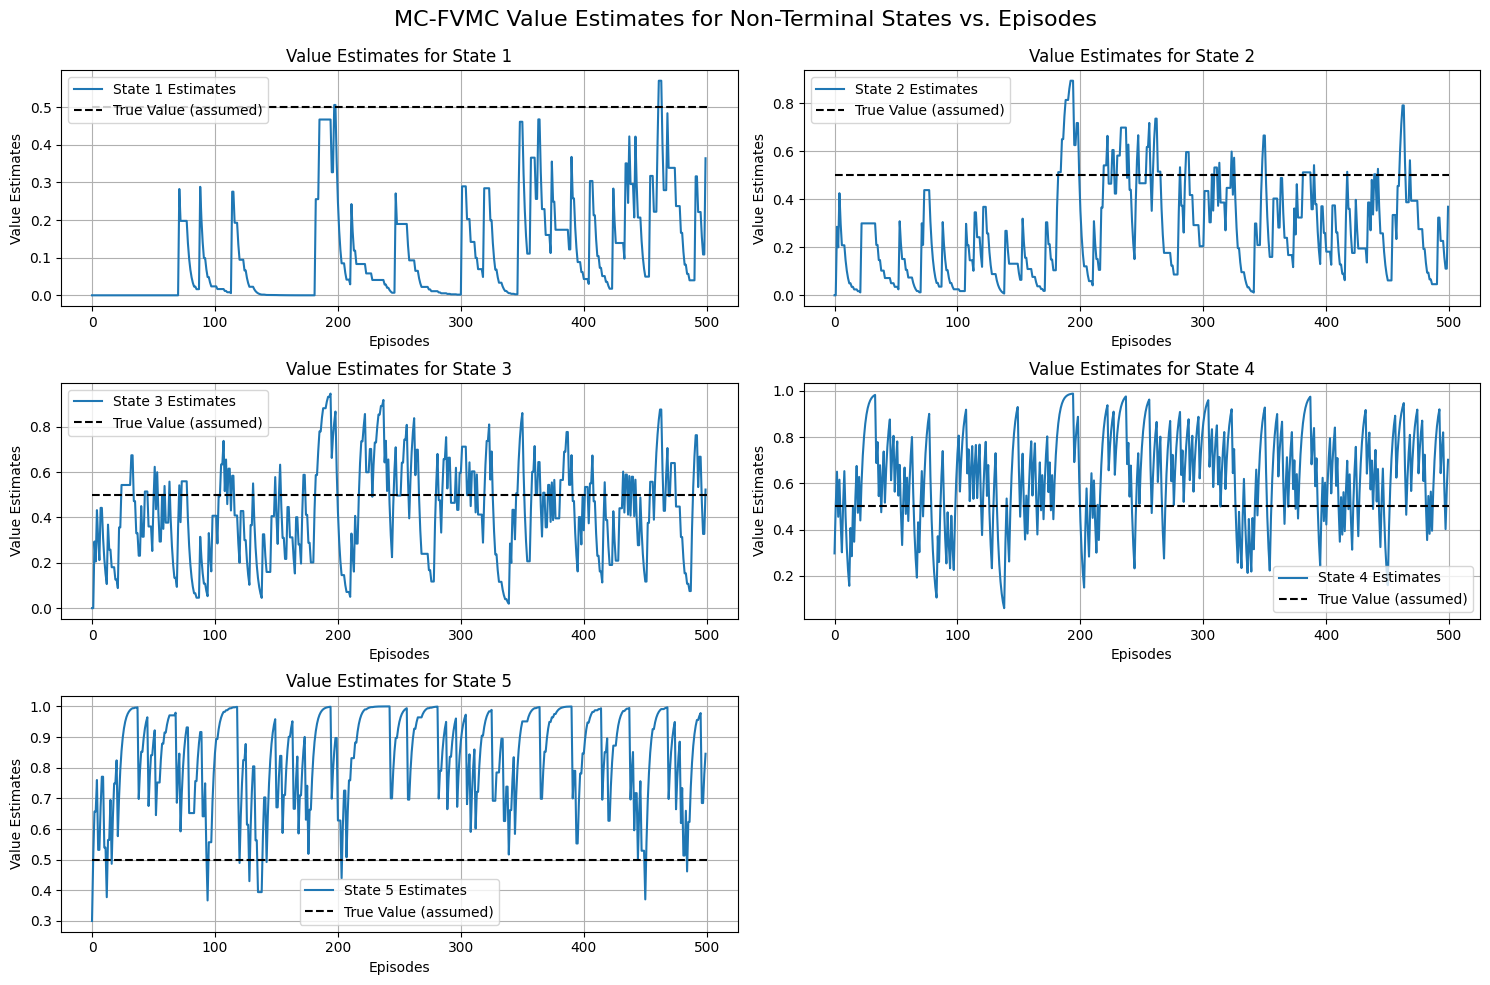

In [189]:
numEpisodes = 500
# part with constant alpha
initialValue = 0.3
finalValue = 0.3
maxSteps = 100
gamma = 0.99
decayType = "linear"
mctype = "EVMC"

state_values = MonteCarloPrediction(env, policy, initialValue, finalValue, maxSteps, numEpisodes, gamma, decayType, mctype)

plt.figure(figsize=(15, 10))

for state in range(1, 6):  # Loop through non-terminal states
    plt.subplot(3, 2, state)
    values_per_state = [state_values[episode][state] for episode in range(numEpisodes)]
    plt.plot(values_per_state, label=f'State {state} Estimates')
    plt.plot([0, numEpisodes], [0.5, 0.5], 'k--', label="True Value (assumed)")
    plt.xlabel('Episodes')
    plt.ylabel('Value Estimates')
    plt.title(f'Value Estimates for State {state}')
    plt.legend()
    plt.grid()
    plt.tight_layout()

plt.suptitle('MC-EVMC Value Estimates for Non-Terminal States vs. Episodes', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()


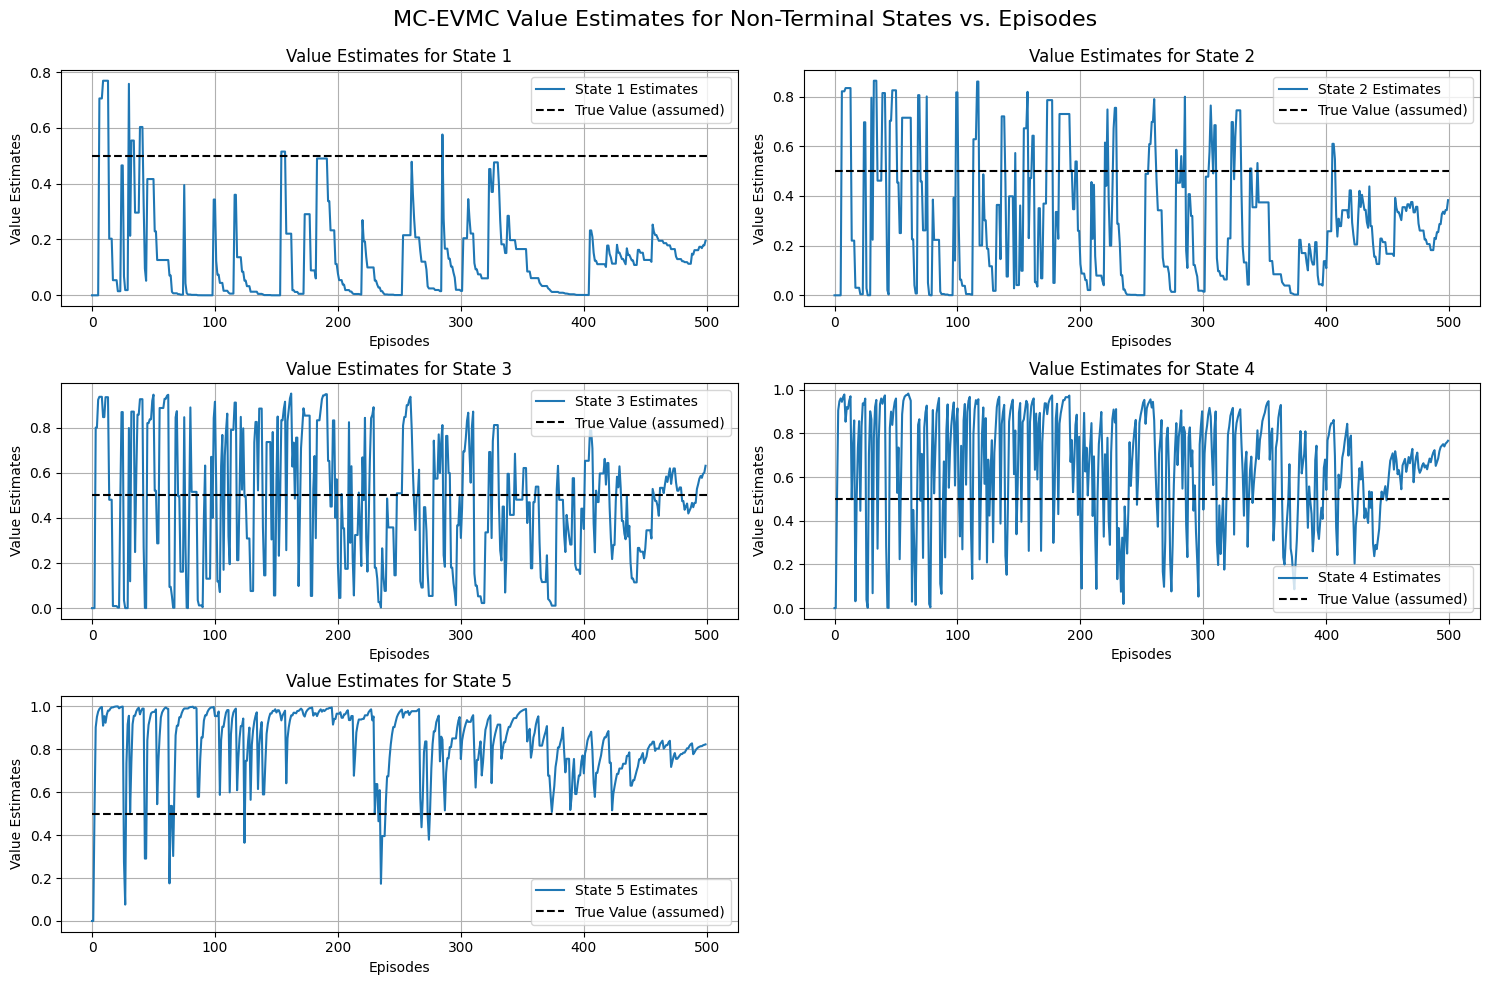

In [191]:
# part with decaying alpha
numEpisodes = 500
# part with constant alpha
initialValue = 0.5
finalValue = 0.01
maxSteps = 100
gamma = 0.99
decayType = "linear"
mctype = "EVMC"

# Implementing a function for deacaying the step parameter for half episodes and using const value afterwards
def decayAlpha_modified(initialValue, finalValue, maxSteps, decayType):

  # stpring the step params in a list
  alphas = []

  decay_rate = (np.log(finalValue/initialValue)) / maxSteps
  for curr_step in range(maxSteps//2):
    curr_alpha = initialValue * np.exp(decay_rate * curr_step)
    alphas.append(curr_alpha)
  for i in range(maxSteps//2, maxSteps):
    alphas.append(curr_alpha)

  return alphas

state_values = MonteCarloPrediction(env, policy, initialValue, finalValue, maxSteps, numEpisodes, gamma, decayType, mctype)

plt.figure(figsize=(15, 10))

for state in range(1, 6):  # Loop through non-terminal states
    plt.subplot(3, 2, state)
    values_per_state = [state_values[episode][state] for episode in range(numEpisodes)]
    plt.plot(values_per_state, label=f'State {state} Estimates')
    plt.plot([0, numEpisodes], [0.5, 0.5], 'k--', label="True Value (assumed)")
    plt.xlabel('Episodes')
    plt.ylabel('Value Estimates')
    plt.title(f'Value Estimates for State {state}')
    plt.legend()
    plt.grid()
    plt.tight_layout()

plt.suptitle('MC-EVMC Value Estimates for Non-Terminal States vs. Episodes', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()